# Deep Learning NLP - Labs

Text Clustering with K-Means and GloVe Word Embeddings using Autoencoders

This exercise aims to show the use of RNNs and embeddings on a text clustering task (NLP).

<br>


#### Dataset
@dataset {consolidated_climate_dataset,  
    author = {Joseph Pollack},  
    title = {Climate Guard Toxic Agent - Dataset},  
    year = {2024},  
    publisher = {Hugging Face},  
    url = { https://huggingface.co/datasets/Tonic/Climate-Guard-Toxic-Agent }  
}
<br>

<br>
@Ricardo Almeida

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [2]:
# Step 1: Import required libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import gensim.downloader as api
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize

In [3]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ricardo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
text_column = 'text'

#### 1. Loading dataset

In [5]:
df = pd.read_parquet("data/climate_text_sample.parquet")

In [6]:
df = df[[text_column]]

In [7]:
df

,text
0,"Since 1938, New England has experienced no hur..."
1,Climate action initiatives often come with sig...
2,"Between 1972 and 2023, the Amazon rainforest l..."
3,"In recent years, climate science has been mark..."
4,"Since 2010, global energy consumption has been..."
...,...
1995,"There's no energy crisis, the elites control t..."
1996,The assertion that no conclusive evidence exis...
1997,The assertion that human emissions of carbon d...
1998,No one has proven that human CO2 emissions cau...


In [8]:
df = df.copy()

#### 2. Download and load pre-trained GloVe model

In [9]:
# Downloading and loading the "glove-wiki-gigaword-300" model
glove_model = api.load("glove-wiki-gigaword-300")  # GloVe model pre-trained on Wikipedia

#### 3. Compute document embeddings by averaging word embeddings

In [10]:
def get_document_embedding(text, glove_model):
    words = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    word_embeddings = [glove_model[word] for word in words if word in glove_model]  # Get embeddings for known words
    if word_embeddings:  # If there are valid word embeddings, take their average
        return np.mean(word_embeddings, axis=0)
    else:  # Fallback if no known words
        return np.zeros(glove_model.vector_size)

In [11]:
# Generate embeddings for each document in 'analyze_text'
df['embedding'] = df[text_column].apply(lambda x: get_document_embedding(x, glove_model))
embeddings = np.vstack(df['embedding'].values)  # Stack into a 2D array for further processing

#### 4. Define and train Autoencoder for dimensionality reduction

In [12]:
# Input shape
input_dim = embeddings.shape[1]
encoding_dim = 2  # 2D bottleneck

# Functional API model definition
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
bottleneck = Dense(encoding_dim, activation='relu', name='bottleneck')(encoded)
decoded = Dense(64, activation='relu')(bottleneck)
output_layer = Dense(input_dim, activation='linear')(decoded)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Encoder model for extracting 2D embeddings
encoder = Model(inputs=input_layer, outputs=bottleneck)

# Compile and train
autoencoder.compile(optimizer=Adam(learning_rate=0.0002), loss='mse')
autoencoder.fit(embeddings, embeddings, epochs=16, batch_size=64, verbose=1)

# Get 2D embeddings
reduced_embeddings_autoencoder = encoder.predict(embeddings)

Epoch 1/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 0.0325
Epoch 2/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 0.0288
Epoch 3/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 0.0208
Epoch 4/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 0.0115
Epoch 5/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050
Epoch 6/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030
Epoch 7/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 0.0026
Epoch 8/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 0.0025
Epoch 9/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 0.0025
Epoch 10/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 0.0025
Epoch 11/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 0.0024
Epoch 12/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 0.0025
Epoch 13/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 0.0024
Epoch 14/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 0.0024
Epoch 15/16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 

In [13]:
# Extract 2D embeddings from Bottleneck Layer
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[2].output)
reduced_embeddings_autoencoder = encoder.predict(embeddings)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step


#### 5. K-Means Clustering on reduced embeddings

In [14]:
# Using K-Means to detect clusters of semantically similar content
kmeans = KMeans(n_clusters=3, n_init='auto', random_state=42)  # Assume 3 clusters for example
labels = kmeans.fit_predict(reduced_embeddings_autoencoder)

In [15]:
# Assign Clusters to the DataFrame
df['cluster'] = labels

In [16]:
# Split the DataFrame into K Groups (Based on Cluster Labels)
# Split into K groups based on the unique cluster labels from K-Means
clustered_groups = [df[df['cluster'] == k] for k in set(labels)]

#### 6. Visualize clusters with Autoencoder embeddings

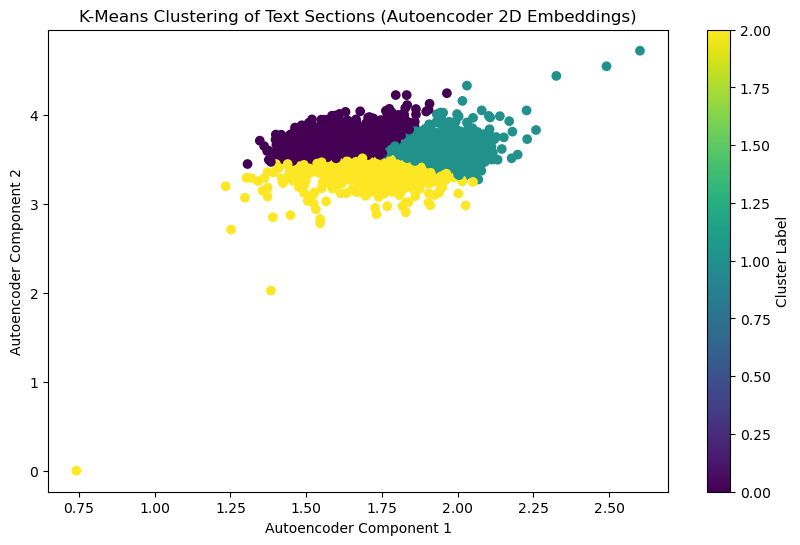

In [17]:
# Plot the 2D embeddings and color by cluster
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_embeddings_autoencoder[:, 0], reduced_embeddings_autoencoder[:, 1], c=labels, cmap='viridis')
plt.colorbar(label="Cluster Label")
plt.title("K-Means Clustering of Text Sections (Autoencoder 2D Embeddings)")
plt.xlabel("Autoencoder Component 1")
plt.ylabel("Autoencoder Component 2")
plt.show()

#### 7. Summary of clusters

In [18]:
for idx, group in enumerate(clustered_groups):
    print(f"\nCluster {idx} - {len(group)} docs\n")
    #print(group[text_column].head(3))  # Print first 3 sections in each cluster
    for t in group[text_column].tail(3):
        print(t[0:200])
        print()


Cluster 0 - 841 docs

The dynamic changes in our weather patterns offer incredible opportunities for innovation and adaptation. Advanced technology allows us to harness extreme conditions for renewable energy production, s

There's no need for costly climate actions; the elites control the economy and society, they can manipulate financial markets to collapse entire industries or create social unrest that destabilizes go

There's no energy crisis, the elites control the power grid—they can ensure stable electricity to run entire cities or cut off power to cripple industries. Keep factories running with coal and oil, fu


Cluster 1 - 624 docs

The assertion that human emissions of carbon dioxide are the primary driver of current global warming remains unproven, despite widespread claims to the contrary. To date, no scientific papers have co

No one has proven that human CO2 emissions cause global warming. If you believe otherwise, provide the top five scientific papers that prove this.